## Performance evaluation

In [1]:
import dill
import math as ma
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd

from numpy.fft import fftshift, fft2, ifft2
from scipy.optimize import minimize
from numpy.random import randn

from utils import gaussian_profile, d_statistic_nll_full

In [2]:
seed = 1234567
alpha_r = 2
alpha_n = 3
cxx_r = 4.0
cxx_n = 4.0
cyy_r = 4.0
cyy_n = 4.0
cth_r = 1.5708
cth_n = 0.0
sig_r = 0.0025
sig_n = 0.0025
half_Delta = [1, 0]
n = 64

## Synthesize some inputs

In [3]:
Delta_x = half_Delta[0]*2
Delta_y = half_Delta[1]*2

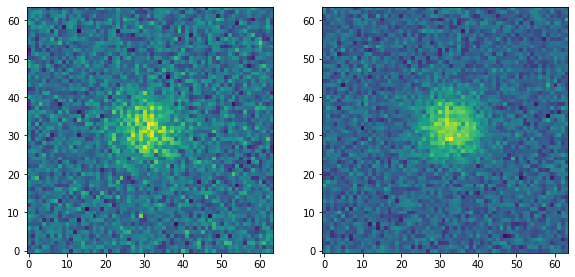

In [4]:
np.random.seed(seed)

xx = np.array([n/2, n/2])
x0_r, y0_r = (xx - half_Delta)
x0_n, y0_n = (xx + half_Delta)

P_r = fftshift(gaussian_profile(n/2, n/2, [n, n], cxx_r, cyy_r, cth_r))
P_n = fftshift(gaussian_profile(n/2, n/2, [n, n], cxx_n, cyy_n, cth_n))
T_P_r = alpha_r * gaussian_profile(x0_r, y0_r, [n, n], cxx_r, cyy_r, cth_r)
T_P_n = alpha_n * gaussian_profile(x0_n, y0_n, [n, n], cxx_n, cyy_n, cth_n)

R = T_P_r + np.random.randn(n, n)*sig_r
N = T_P_n + np.random.randn(n, n)*sig_n

R_hat, N_hat, P_r_hat, P_n_hat = map(np.fft.fft2,[R, N, P_r, P_n])

plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.imshow(R, origin='lower')
plt.subplot(1,3,2); plt.imshow(N, origin='lower')

## Visualizing the error surface (without $\alpha_r$, $\alpha_n$)

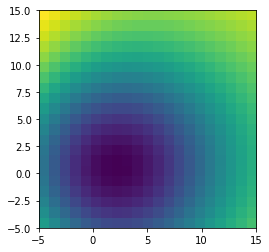

In [5]:
Delta_x_ = np.linspace(-5, 15, 21)
Delta_y_ = np.linspace(-5, 15, 21)
alpha_r_ = np.linspace(1, 5, 21)
alpha_n_ = np.linspace(1, 5, 21)

nll = np.zeros((Delta_x_.shape[0], Delta_y_.shape[0]))
for i, Delta_y__ in enumerate(Delta_y_):
    for j, Delta_x__ in enumerate(Delta_x_):
        nll[i,j] = d_statistic_nll_full(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, 
                                        xx, Delta_x__, Delta_y__, alpha_r, alpha_n)

fig, ax = plt.subplots(figsize=(4,4))
ax.imshow((nll-np.min(nll)), extent=[Delta_x_[0], Delta_x_[-1], Delta_y_[0], Delta_y_[-1]], origin='lower')

## Find maximum-likelihood using Nelder-Mead

In [6]:
x0 = [1, 1, 1, 1]
nll = lambda x : d_statistic_nll_full(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx, x[0], x[1], x[2], x[3])
min_ = minimize(nll, x0, method='Nelder-Mead', options={'disp': False, 'ftol': 1e-15})

nll_hess = nd.Hessian(nll, step=0.01)
nll_hess_eval = nll_hess(min_.x)
nll_cov = np.linalg.inv(nll_hess_eval)
w, v = np.linalg.eig(nll_cov[:4, :4])

truth = np.array([Delta_x, Delta_y, alpha_r, alpha_n])
estim = min_.x
sigmas = w**0.5
errors = estim - truth

np.set_printoptions(precision=3, floatmode='fixed', sign='+')

print('truth             ', truth)
print('estimate          ', estim)
print('sigmas            ', sigmas)
print('errors            ', errors)
print('errors in sigmas  ', errors / sigmas)

truth              [2 0 2 3]
estimate           [+1.991 +0.382 +2.049 +3.011]
sigmas             [+12.032  +0.202  +0.229  +0.051]
errors             [-0.009 +0.382 +0.049 +0.011]
errors in sigmas   [-7.269e-04 +1.891e+00 +2.125e-01 +2.109e-01]


## Perform MCMC sampling

In [2]:
import emcee
import multiprocessing
import corner

In [8]:
ndim, nwalkers = 4, 100
num_threads = int(multiprocessing.cpu_count() / 2)

def lnprob(params, R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx):    
    return -d_statistic_nll_full(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx, 
                                 params[0], params[1], params[2], params[3])

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=num_threads, 
                                args=(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx))

pos = [estim + 0.5*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 750);
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

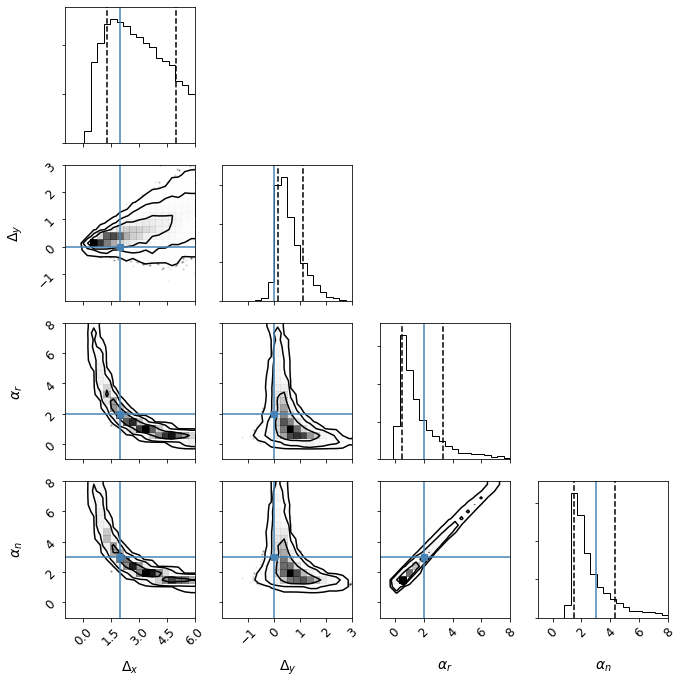

In [19]:
from matplotlib import rcParams
rcParams["font.size"] = 12

corner.corner(samples, 
              labels=["$\\Delta_x$", "$\\Delta_y$", "$\\alpha_r$", "$\\alpha_n$"], 
              truths=truth, 
              quantiles=(0.16, 0.84),
              levels=(0.68, 0.95, 0.997), label_kwargs={"fontsize": 14},
              range=((-1, 6), (-2, 3), (-1, 8), (-1, 8)));
plt.tight_layout()

plt.savefig("figures/discrim_full_degenerate.pdf")

In [10]:
def reparam(parr):
    
    Delta, theta, alpha_r_minus_alpha_n, alpha_r_plus_alpha_n = parr
    
    Delta_x = Delta*ma.cos(theta)
    Delta_y = Delta*ma.sin(theta)
    alpha_r = (alpha_r_minus_alpha_n + alpha_r_plus_alpha_n) / 2
    alpha_n = (alpha_r_plus_alpha_n - alpha_r_minus_alpha_n) / 2
    
    return np.array([Delta_x, Delta_y, alpha_r, alpha_n])


def reparam_inv(parr):
    
    Delta_x, Delta_y, alpha_r, alpha_n = parr
    
    Delta = (Delta_x**2 + Delta_y**2)**0.5
    theta = ma.atan2(Delta_y, Delta_x)
    alpha_r_minus_alpha_n = alpha_r - alpha_n
    alpha_r_plus_alpha_n = alpha_r + alpha_n
    
    return np.array([Delta, theta, alpha_r_minus_alpha_n, alpha_r_plus_alpha_n])

In [11]:
ndim, nwalkers = 4, 100
num_threads = int(multiprocessing.cpu_count() / 2)

def lnprob_(params, R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx):
    reparams = reparam([params[0], params[1], params[2], params[3]])
    reparam_jac = nd.Jacobian(reparam, step=0.001)
    reparam_jac_eval = reparam_jac(params)
    s, ld = np.linalg.slogdet(reparam_jac_eval)
    ll_jac = s*ld
    ll_d_full = -d_statistic_nll_full(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx, 
                                      reparams[0], reparams[1], reparams[2], reparams[3])
    return ll_jac + ll_d_full

sampler_ = emcee.EnsembleSampler(nwalkers, ndim, lnprob_, threads=num_threads, 
                                args=(R_hat, N_hat, P_r_hat, P_n_hat, sig_r, sig_n, xx))

pos_ = [reparam_inv([estim[0], estim[1], estim[2], estim[3]]) + 0.5*np.random.randn(ndim) for i in range(nwalkers)]
sampler_.run_mcmc(pos_, 750);
samples_ = sampler_.chain[:, 100:, :].reshape((-1, ndim))

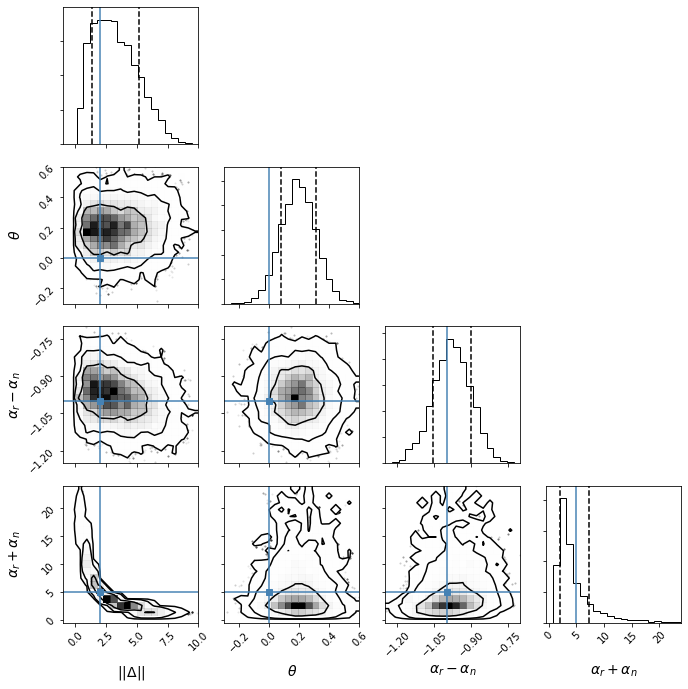

In [4]:
corner.corner(samples_, 
              labels=["$\||\Delta||$", "$\\theta$", "$\\alpha_r - \\alpha_n$", "$\\alpha_r + \\alpha_n$"], 
              truths=reparam_inv([truth[0], truth[1], truth[2], truth[3]]),
              quantiles=(0.16, 0.84),
              levels=(0.68, 0.95, 0.997), label_kwargs={"fontsize": 14},
              range=((-1, 10), (-0.3, 0.6), (-1.25, -0.7), (-0.5, 24)));
plt.tight_layout()

plt.savefig("figures/discrim_full_degenerate_reparam.pdf")

In [5]:
#dill.dump_session('output/discrim_full_degenerate.pkl')
dill.load_session('output/discrim_full_degenerate.pkl')

/Users/ofer/Dropbox/Projects/time_delay/venv/lib/python3.7/site-packages/dill/_dill.py:472: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  obj = StockUnpickler.load(self)
/Users/ofer/Dropbox/Projects/time_delay/venv/lib/python3.7/site-packages/dill/_dill.py:472: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  obj = StockUnpickler.load(self)
/Users/ofer/Dropbox/Projects/time_delay/venv/lib/python3.7/site-packages/dill/_dill.py:472: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  obj = StockUnpickler.load(self)
/Users/ofer/Dropbox/Projects/time_delay/venv/lib/python3.7/site-packages/dill/_dill.py:472: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.